# **Homework 8 - Anomaly Detection**

If there are any questions, please contact mlta-2023-spring@googlegroups.com

Slide:    [Link](https://docs.google.com/presentation/d/18LkR8qulwSbi3SVoLl1XNNGjQQ_qczs_35lrJWOmHCk/edit?usp=sharing)　Kaggle: [Link](https://www.kaggle.com/t/c76950cc460140eba30a576ca7668d28)

# Set up the environment


## Package installation

In [1]:
# Training progress bar
!pip install -q qqdm

## Downloading data

In [2]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh |  bash
!apt-get install -y --allow-unauthenticated git-lfs

Detected operating system as Ubuntu/focal.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Detected apt version as 2.0.9
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... Packagecloud gpg key imported to /etc/apt/keyrings/github_git-lfs-archive-keyring.gpg
done.
Running apt-get update... done.

The repository is setup! You can now install packages.



The following packages will be upgraded:
  git-lfs
1 upgraded, 0 newly installed, 0 to remove and 84 not upgraded.
Need to get 7419 kB of archives.
After this operation, 4936 kB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu focal/main amd64 git-lfs amd64 3.3.0 [7419 kB]
Fetched 7419 kB in 1s (7985 kB/s)
(Reading database ... 111522 files and directories currently installed.)
Preparing to unpack .../git-lfs_3.3.0_amd64.deb ...
Unpacking git-lfs (3.3.0) 

In [3]:
!git clone https://github.com/chiyuanhsiao/ml2023spring-hw8

Cloning into 'ml2023spring-hw8'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 2), reused 8 (delta 0), pack-reused 0
Receiving objects: 100% (11/11), done.
Resolving deltas: 100% (2/2), done.


In [4]:
%cd /kaggle/working/ml2023spring-hw8
!git lfs install
!git lfs pull

/kaggle/working/ml2023spring-hw8
Updated Git hooks.
Git LFS initialized.


# Import packages

In [5]:
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from torch.optim import Adam, AdamW
from qqdm import qqdm, format_str
import pandas as pd

# Loading data

In [6]:
train = np.load('/kaggle/working/ml2023spring-hw8/trainingset.npy', allow_pickle=True)
test = np.load('/kaggle/working/ml2023spring-hw8/testingset.npy', allow_pickle=True)

print(train.shape)
print(test.shape)

(100000, 64, 64, 3)
(19636, 64, 64, 3)


## Random seed
Set the random seed to a certain value for reproducibility.

In [7]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(42)

# Autoencoder

# Models & loss

In [8]:
class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64 * 64 * 3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(), 
            nn.Linear(256, 64), 
            nn.ReLU(), 
            nn.Linear(64, 10)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(), 
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(), 
            nn.Linear(1024, 64 * 64 * 3), 
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 24, 4, stride=2, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Conv2d(24, 24, 4, stride=2, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.Conv2d(48, 96, 4, stride=2, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(96*4*4, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 10),
            nn.BatchNorm1d(10),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 96*4*4),
            nn.BatchNorm1d(96*4*4),
            nn.ReLU(),
            nn.Unflatten(1, (96, 4, 4)),
            nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x     



class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten()
        )
        self.enc_out_1 = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(64*4*4, 128),
            #nn.BatchNorm1d(128),
            nn.ReLU(),
            
            nn.Dropout(0.2),
            nn.Linear(128, 10),
            #nn.BatchNorm1d(10),
            nn.ReLU()
        )
        self.enc_out_2 = nn.Sequential(
            #nn.Conv2d(48, 12, 4, stride=2, padding=1),
            #nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64*4*4, 128),
            #nn.BatchNorm1d(128),
            nn.ReLU(),
            
            nn.Dropout(0.2),
            nn.Linear(128, 10),
            #nn.BatchNorm1d(10),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(10, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 32*4*4),
            nn.BatchNorm1d(32*4*4),
            nn.ReLU(),
            nn.Unflatten(1, (32, 4, 4)),
            nn.ConvTranspose2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.enc_out_1(h1), self.enc_out_2(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD

In [9]:
class ensemble(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 64 * 3, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(), 
            nn.Dropout(0.2),
            nn.Linear(256, 64), 
            nn.BatchNorm1d(64),
            nn.ReLU(), 
        )
        
        self.encoder_2 = nn.Sequential(
            nn.Conv2d(3, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(128*4*4, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
                nn.Linear(192, 128*4*4),
                nn.BatchNorm1d(128*4*4),
                nn.ReLU(),
                nn.Unflatten(1, (128, 4, 4)),
                nn.ConvTranspose2d(128, 256, 4, stride=2, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1),
                nn.Tanh(),
        )
        
    def encoder(self, x):
        x1 = self.encoder_1(x)
        x2 = self.encoder_2(x)
        return torch.cat((x1, x2), 1)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
class Residual_Block(nn.Module):
    def __init__(self, ic, oc, stride=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(ic, oc, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(oc),
            nn.ReLU(inplace=True)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(oc, oc, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(oc),
        )
        
        self.relu = nn.ReLU(inplace=True)
    
        self.downsample = None
        if stride != 1 or (ic != oc):
            self.downsample = nn.Sequential(
                nn.Conv2d(ic, oc, kernel_size=1, stride=stride),
                nn.BatchNorm2d(oc),
            )
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        
        if self.downsample:
            residual = self.downsample(x)
            
        out += residual
        return self.relu(out)
    
class ResNet(nn.Module):
    def __init__(self, block=Residual_Block, num_layers=[2, 1, 1, 1]):
        super().__init__()
        self.preconv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        self.layer0 = self.make_residual(block, 32, 64,  num_layers[0], stride=2)
        self.layer1 = self.make_residual(block, 64, 128, num_layers[1], stride=2)
        self.layer2 = self.make_residual(block, 128, 128, num_layers[2], stride=2)
        self.layer3 = self.make_residual(block, 128, 64, num_layers[3], stride=2)
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(64*4*4, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 64*4*4),
            nn.BatchNorm1d(64*4*4),
            nn.ReLU(),
            nn.Unflatten(1, (64, 4, 4)),
            nn.ConvTranspose2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )
    def make_residual(self, block, ic, oc, num_layer, stride=1):
        layers = []
        layers.append(block(ic, oc, stride))
        for i in range(1, num_layer):
            layers.append(block(oc, oc))
        return nn.Sequential(*layers)
    
    def encoder(self, x):
        x = self.preconv(x)
        x = self.layer0(x) #64*64 --> 32*32
        x = self.layer1(x) #32*32 --> 16*16
        x = self.layer2(x) #16*16 --> 8*8
        x = self.layer3(x) #8*8 --> 4*4
        x = self.fc(x)
        return x
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    
class Auxiliary(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(64, 64*4*4),
            nn.BatchNorm1d(64*4*4),
            nn.ReLU(),
            nn.Unflatten(1, (64, 4, 4)),
            nn.ConvTranspose2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )
        
    def forward(self, x):
        return self.decoder(x)

# Dataset module

Module for obtaining and processing data. The transform function here normalizes image's pixels from [0, 255] to [-1.0, 1.0].


In [11]:
class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors):
        self.tensors = tensors
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)
        
        self.transform = transforms.Compose([
          transforms.Lambda(lambda x: x.to(torch.float32)),
          transforms.Lambda(lambda x: 2. * x/255. - 1.),
        ])
        
    def __getitem__(self, index):
        x = self.tensors[index]
        
        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.tensors)

# Training

## Configuration


In [12]:
# Training hyperparameters
num_epochs = 70
batch_size = 128
learning_rate = 1e-3

# Build training dataloader
x = torch.from_numpy(train)
train_dataset = CustomTensorDataset(x)


train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Model
model_type = 'resnet'   # selecting a model type from {'cnn', 'fcn', 'vae', 'resnet'}
model_classes = {'fcn': fcn_autoencoder(), 'cnn': conv_autoencoder(), 'vae': VAE(), 'ensemble':ensemble(), 'resnet':ResNet()}
model = model_classes[model_type].cuda()
aux = Auxiliary().cuda()

# Loss and optimizer

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
optimizer_a = torch.optim.AdamW(aux.parameters(), lr=learning_rate)

## Training loop

In [13]:
best_loss = np.inf

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description'), dynamic_ncols=False)
for epoch in qqdm_train:
    tot_loss = list()
    tot_loss_a = list()
    aux.train()
    temperature = epoch // 2 + 1
    for data in train_dataloader:
        # ===================loading=====================
        img = data.float().cuda()
        if model_type in ['fcn']:
            img = img.view(img.shape[0], -1)
        # ===================train autoencoder=====================
        model.train()
        output = model(img)
        if model_type in ['vae']:
            loss = loss_vae(output[0], img, output[1], output[2], criterion)
        else:
            loss = criterion(output, img)
        loss = loss.mean()
        tot_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ===================train aux=====================
        model.eval()
        z = model.encoder(img).detach_()
        output = output.detach_()
        output_a = aux(z)
        loss_a = (criterion(output_a, output).mul(temperature).exp())*criterion(output_a, img)
        loss_a = loss_a.mean()
        tot_loss_a.append(loss_a.item())
        optimizer_a.zero_grad()
        loss_a.backward()
        optimizer_a.step()
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, 'best_model_{}.pt'.format(model_type))
        torch.save(aux, 'best_model_a_{}.pt'.format(model_type))
    # ===================log========================
    qqdm_train.set_infos({
        'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
        'loss':f'{np.mean(tot_loss):.5f}',
        'loss_a':f'{np.mean(tot_loss_a):.5f}'
    })
    

# ===================save_last========================
torch.save(model, 'last_model_{}.pt'.format(model_type))
torch.save(aux, 'last_model_a_{}.pt'.format(model_type))

 Iters    Elapsed Time      Speed                                               
 0/70           -             -                                                 
Description   0.0% |                                       |                     Iters    Elapsed Time      Speed    epoch   loss                               
 1/70   00:02:20<02:42:07  0.01it/s  1/70   0.15536                             
 loss_a                                                                         
 0.18289                                                                        
Description   1.4% |                                       |                     Iters    Elapsed Time      Speed    epoch   loss                               
 2/70   00:04:37<02:37:11  0.01it/s  2/70   0.06490                             
 loss_a                                                                         
 0.06468                                                                        
Description   2.9% |█         

# Inference
Model is loaded and generates its anomaly score predictions.

## Initialize
- dataloader
- model
- prediction file

In [14]:
eval_batch_size = 200

# build testing dataloader
data = torch.tensor(test, dtype=torch.float32)
test_dataset = CustomTensorDataset(data)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=eval_batch_size, num_workers=1)
eval_loss = nn.MSELoss(reduction='none')

# load trained model
checkpoint_path = f'best_model_{model_type}.pt'
checkpoint_path_a = f'best_model_a_{model_type}.pt'
model = torch.load(checkpoint_path).cuda()
aux = torch.load(checkpoint_path_a).cuda()
model.eval()
 
# prediction file 
out_file = 'prediction.csv'
out_file_a = 'prediction_a.csv'

In [15]:
anomality = list()
auxs = list()
with torch.no_grad():
  for i, data in enumerate(test_dataloader):
    img = data.float().cuda()
    if model_type in ['fcn']:
      img = img.view(img.shape[0], -1)
    z = model.encoder(img)
    output, output_a = model.decoder(z), aux(z)
    if model_type in ['vae']:
      output = output[0]
    if model_type in ['fcn']:
        loss = eval_loss(output, img).mean(-1)
    else:
        loss = eval_loss(output, img).mean([1, 2, 3])
        loss_a = eval_loss(output_a, img).mean([1, 2, 3])
    anomality.append(loss)
    auxs.append(loss_a)

anomality = torch.cat(anomality, axis=0)
anomality = torch.sqrt(anomality).reshape(len(test), 1).cpu().numpy()
auxs = torch.cat(auxs, axis=0)
auxs = torch.sqrt(auxs).reshape(len(test), 1).cpu().numpy()

df = pd.DataFrame(anomality, columns=['score'])
df.to_csv(out_file, index_label = 'ID')
df_a = pd.DataFrame(auxs, columns=['score'])
df_a.to_csv(out_file_a, index_label = 'ID')

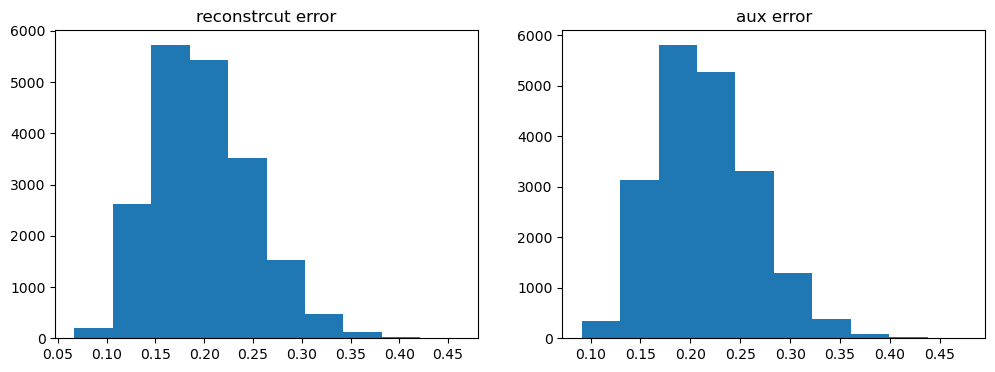

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title('reconstrcut error')
plt.hist(df.score)
plt.subplot(122)
plt.title('aux error')
plt.hist(df_a.score)
plt.show()